# Table 2 GPC Results

This notebook demonstrates the results obtained by us for the Generalized Phase Contrast (GPC) method. The parameters for the GPC filter are selected after experimentation and they are fixed in this implementation. 

### Reproducing Results

```
Run all cells
```

In [1]:
# Importing all required libraries
import sys
sys.path.append('../')

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil

from torchvision.utils import make_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

from modules.dataloaders import *
from modules.eval_metrics import *

/n/home06/kherath/.conda/envs/FYPD2NN/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Required custom functions:

In [2]:
def circ(n_neurons_input, neuron_size, delta_fr=16):
    '''
        Function to obtain the filter mask with the central region
        
            Args:
                n_neurons_input : Number of neurons in the spatial domain input | int 
                neuron_size     : Size of a neuron in the spatial domain | float 
                delta_fr        : Radius of the central region of the filter in the frequency domain | float

            Returns:
                central_filter  : Filter mask | torch.Tensor     
    '''

    dx= neuron_size
    N= n_neurons_input
    
    # Creating the fx, fy grid
    fx = torch.arange(-1/(2*dx),1/(2*dx),1/(N*dx)) 
    fx = torch.tile(fx, (1,N)).view(N,N).to(torch.cfloat)
    fy = torch.arange(1/(2*dx),-1/(2*dx),-1/(N*dx)).view(N,1)
    fy = torch.tile(fy, (1,N)).view(N,N).to(torch.cfloat)
    
    central_filter = (abs(fx)**2 + abs(fy)**2 <= (delta_fr)**2)

    return central_filter

def input_circle(n_i,sf, circle = False, device='cpu'):
    '''
        Function to obtain a circular mask to apply on the input
    
            Args:
                n_i    : Number of neurons in the spatial domain input | int 
                sf     : Shrink factor | int 
                circle : Indicates if a circular mask is required | bool
                device : The device on which the model runs

            Returns:
                circ   : Circular mask for the input | torch.Tensor
    '''
    
    if circle:
        rc = (n_i//2)//sf # Radius of the input region of interest
        
        # x,y grid
        xc = torch.arange(-n_i//2,n_i//2,1) 
        xc = torch.tile(xc, (1,n_i)).view(n_i,n_i).to(torch.cfloat)
        yc = torch.arange(n_i//2,-n_i//2,-1).view(n_i,1)
        yc = torch.tile(yc, (1,n_i)).view(n_i,n_i).to(torch.cfloat)

        circ = (abs(xc)**2 + abs(yc)**2 <= (rc)**2).to(torch.float32).view(1,n_i,n_i).to(device)
    else:
        circ = torch.ones(1,n_i,n_i).to(device)
    
    return circ

In [3]:
def plot_phase_amp_set_gpc(pred_img_set, gt_img_set,scale, caption= 'no caption', cfg = None, return_fig = False):    
    '''
        Function to plot phases and amplitudes of ground truth and predicted complex images
        (Mainly used for GPC)

            Args:
                pred_img_set : Predicted image set | torch.Tensor
                gt_img_set   : Ground truth complex image set | torch.Tensor
                scale        : Scaling factor of the reconstructed image | float
                caption      : Caption for logging and titles | string
                cfg          : Configuration dictionary | dict
                return_fig   : Whether to return the figure | bool

            Returns:
                fig          : figures for results | Figure  
    '''
    
    pred_img_set= pred_img_set.unsqueeze(dim= 1)[10:14] # for bacteria it's 0:4, for other datasets it's 10:14
    gt_img_set= gt_img_set.unsqueeze(dim= 1)[10:14]
    gt_angle = gt_img_set.detach().cpu().imag
    gt_abs = gt_img_set.detach().cpu().real
    
    if cfg['get_dataloaders'] == 'get_bacteria_dataloaders': # To visualize bacteria reconstruction clearly
        pred_vmax = 0.013
    else:
        pred_vmax = 1
  
    fig = plt.figure(figsize= (10,3))
    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(make_grid(gt_angle, nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY),vmin=0, vmax=1)
    plt.colorbar()
    plt.title('Ground Truth : Phase')
    
    plt.subplot(1,3,2)
    plt.imshow(cv2.cvtColor(make_grid(gt_abs, nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY),vmin=0,vmax=1)
    plt.colorbar()
    plt.title('Ground Truth : Amplitude')
    
    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(make_grid(pred_img_set.abs().detach().cpu(), nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY),vmin=0,vmax=pred_vmax)
    plt.colorbar()
    plt.title("Reconstructed : Intensity")
    
    # Creating results directory for GPC method
    if os.path.isdir(f'../results/GPC'):
        print(f'Deleting existing directory : ../results/GPC')
        shutil.rmtree(f'../results/GPC')
        
    os.mkdir(f'../results/GPC')
    
    plt.savefig('../results/GPC/'+caption+'.png',dpi=300,bbox_inches='tight',pad_inches = 0)
            
    if return_fig:
        return fig
    else:
        plt.show()

In [4]:
def validation_loop(cfg):
    '''
        Function to run the test set and plot results
        
            Args:
                cfg: Configurations dictionary
    '''
    
    img_size = cfg['img_size']
    shrinkFactor= cfg['shrink_factor']
    A = cfg['A']
    B = cfg['B']
    theta = cfg['theta']
    dfr = cfg['dfr']
    device = cfg['device']
    data_loader = cfg['get_dataloaders']
    scale = cfg['scale']
    
    # Constructing the GPC filter
    C = torch.tensor(B * (1/A) * np.exp(1j * theta) - 1)
    H = A * (1 + C*circ(img_size, 0.0003, dfr))

    ssim11_rd = [] # Store the SSIM values
    l1 = [] # Store the L1 distance

    if(shrinkFactor!=1):
        # To obtain the starting position and ending position of the original image within the padded image
        csize = int(img_size/shrinkFactor)
        spos  = int((img_size - csize)/2)
        epos  = spos + csize
    else:
        spos = 0
        epos = img_size

    incircle = input_circle(img_size,shrinkFactor, circle = True, device=device) # Creating a circular mask to apply on the input

    # Loading the test dataset loader
    if data_loader == 'get_qpm_np_dataloaders' or data_loader == 'get_bacteria_dataloaders':
        _, val_loader = eval(data_loader)(img_size, 
                                 32, 
                                 task_type= 'phase2intensity',
                                 shrinkFactor = shrinkFactor,
                                 cfg = cfg)
    elif data_loader == 'get_mnist_dataloaders':
        _, val_loader = get_mnist_dataloaders(img_size, 
                                 32, 
                                 task_type= 'phase2intensity',
                                 shrinkFactor = shrinkFactor,
                                 cfg=cfg
                                )

    for idx, (x, y) in enumerate(val_loader):

        ground_truth = x[:,0].to(device) * incircle # Remove channel dimension of the input
        X = torch.fft.fftshift(torch.fft.fft2(ground_truth)) # Obtaining the Fourier transform of the input
        filtered = X*H.unsqueeze(dim=0).to(device) # Applying the GPC filter
        out = torch.fft.ifft2(torch.fft.ifftshift(filtered)).to(torch.complex64) # Reconstructed image

        out = out[:,spos:epos,spos:epos] # Crop the reconstructed image

        if data_loader == 'get_qpm_np_dataloaders' or data_loader == 'get_bacteria_dataloaders':
            angle_max = eval(cfg['angle_max'])
            # CLIP ANGLE TO -> [0, angle_max]
            y = torch.clip(y, min= 0, max= angle_max).to(device) * incircle # y will have the original phase image
            
            gt = y[:,0].to(device)[:,spos:epos,spos:epos] /angle_max # Crop and normalize the groundtruth image
            gt_angle = gt
            ground_truth = ground_truth[:,spos:epos,spos:epos].abs() + 1j*gt # Preparing the groundtruth in a suitable format for the plot functions
        else:            
            ground_truth = ground_truth[:,spos:epos,spos:epos] # Crop the groundtruth image
            gt_angle = (ground_truth.angle()%(2*np.pi))/np.pi
            gt_abs = ground_truth.abs()
            ground_truth = gt_abs + 1j*gt_angle # Preparing the groundtruth in a suitable format for the plot functions

        pred_out= scale * (out.abs()**2)

        ssim11_rd.append(ssim_pytorch(pred_out, gt_angle, k= 11, range_independent = False))
        l1.append(L1_distance(pred_out, gt_angle))

    print('ssim11:', np.mean(ssim11_rd))
    print('l1:', np.mean(l1))
    
    plot_phase_amp_set_gpc(pred_out, ground_truth,caption='GPC_reconstructed',scale=scale,cfg=cfg) # Plot the reconstructions of the final evaluated batch



### Keywords in the configs dictionary:

* **device**: The device the model runs on
* **A**: Amplitude coefficient of the transmission coefficients in the outer region of the GPC filter
* **B**: Amplitude coefficient of the transmission coefficients in the central region of the GPC filter
* **theta**: The applied phase shift to the light falling onto the central region of the filter
* **dfr**: Radius of the central region of the filter in the fourier plane
* **lambda_**: Wavelength of the light (m)
* **neuron_size**: Size of an element of the input image (m)
* **img_size**: Size of the input image after padding
* **shrink_factor**: The padding factor of the input image. 
* **n_layers**: Number of optical layers in the model
* **train_batch_size**: Training batch size
* **torch_seed**: Pytorch seed for rand functions
* **task_type**: Indicates phase-to-intensity conversion task. Defaults to 'phase2intensity'
* **scale**: Scaling factor of the reconstructed image
* **get_dataloaders**: Options for supporting dataloaders of the datasets:
    * MNIST                   : 'get_mnist_dataloaders'
    * HeLA and HeLA $[0,\pi]$ : 'get_qpm_np_dataloaders'
    * Bacteria                : 'get_bacteria_dataloaders'
* **angle_max**: Options that indicate the maximum phase value that can be set in the dataset:
    * MNIST         : 'np.pi'
    * HeLA          : '2*np.pi'
    * HeLA $[0,\pi]$ : 'np.pi'
    * Bacteria      : '2*np.pi'
* **dataset_debug_opts**: Supporting options:
    * 'clip_phase' : Clip the phase to the angle indicated in angle max 
    * 'clip_phase@phase_set_pi' : Clip the phase to the angle indicated in angle max and then set the maximum angle to $\pi$ (This option is only available for the HeLA dataset).

In [5]:
# Common configurations for all datasets
configs = {
    'device': 'cpu',
    
    'A':1,
    'B':1,
    'theta': np.pi/2,
    'dfr':52,

    'lambda_': 6.328e-07,
    'neuron_size': 3.164e-07,
    'img_size': 128,
    'shrink_factor': 4,
    'n_layers': 1,

    'train_batch_size': 32,
    'torch_seed': 1,

    'task_type': 'phase2intensity',
}

### Results for MNIST dataset

ssim11: 0.5134439852467195
l1: 0.18526464206649657


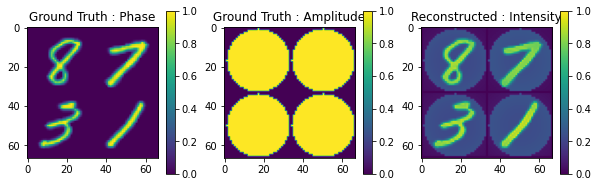

In [6]:
MNIST_configs = {
        'scale': 0.46,
        'get_dataloaders' : 'get_mnist_dataloaders',

        'angle_max': 'np.pi',
        'dataset_debug_opts': 'clip_phase'
}
configs.update(MNIST_configs)
validation_loop(configs)

### Results for HeLA dataset

ssim11: 0.40561873400036025
l1: 0.12704304890597568
Deleting existing directory : ../results/GPC


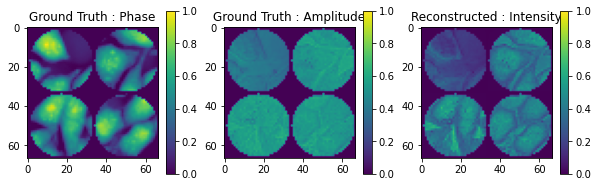

In [7]:
HeLa_configs = {
        'scale': 1.44,
        'get_dataloaders' : 'get_qpm_np_dataloaders',

        'angle_max': '2*np.pi',
        'dataset_debug_opts': 'clip_phase'
}
configs.update(HeLa_configs)
validation_loop(configs)

### Results for HeLA $[0,\pi]$ dataset

ssim11: 0.5651590265333652
l1: 0.17259332362343283
Deleting existing directory : ../results/GPC


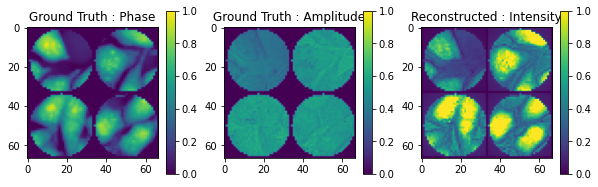

In [8]:
HeLapi_configs = {
        'scale': 2.8,
        'get_dataloaders' : 'get_qpm_np_dataloaders',

        'angle_max': 'np.pi',
        'dataset_debug_opts': 'clip_phase@phase_set_pi'
}
configs.update(HeLapi_configs)
validation_loop(configs)

### Results for Bacteria dataset

In [9]:
bacteria_configs = {
        'scale': 0.01,
        'get_dataloaders' : 'get_bacteria_dataloaders',

        'angle_max': '2*np.pi',
        'dataset_debug_opts': 'clip_phase'
}
configs.update(bacteria_configs)
validation_loop(configs)